In [1]:
import pandas as pd

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
wine = pd.read_csv('wine_quality.csv')

In [19]:
(wine.isna().sum()/wine.shape[0]).apply(lambda x: f'{x:.4%}')

fixed acidity           15.3148%
volatile acidity        14.6067%
citric acid              6.9878%
residual sugar           3.0783%
chlorides                0.0000%
free sulfur dioxide      2.1241%
total sulfur dioxide    11.4514%
density                  0.0000%
pH                       2.7705%
sulphates                9.6352%
alcohol                  2.8167%
quality                  9.0965%
type                    12.3134%
dtype: object

In [9]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5502.000000,5548.000000,6043.00000,6297.000000,6497.000000,6359.000000,5753.000000,6497.000000,6317.000000,5871.000000,6314.000000,5906.000000
mean,7.188804,0.337143,0.31878,5.445395,0.056034,30.553939,116.712150,0.994697,3.217977,0.529256,10.497238,5.818998
std,1.276449,0.161848,0.14383,4.764499,0.035034,17.699470,55.950859,0.002999,0.161019,0.148786,1.193810,0.872916
min,3.800000,0.080000,0.00000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.25000,1.800000,0.038000,17.000000,80.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.31000,3.000000,0.047000,29.000000,119.000000,0.994890,3.210000,0.500000,10.300000,6.000000
75%,7.600000,0.400000,0.39000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.66000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [12]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5502 non-null   float64
 1   volatile acidity      5548 non-null   float64
 2   citric acid           6043 non-null   float64
 3   residual sugar        6297 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6359 non-null   float64
 6   total sulfur dioxide  5753 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6317 non-null   float64
 9   sulphates             5871 non-null   float64
 10  alcohol               6314 non-null   float64
 11  quality               5906 non-null   float64
 12  type                  5697 non-null   object 
dtypes: float64(12), object(1)
memory usage: 660.0+ KB


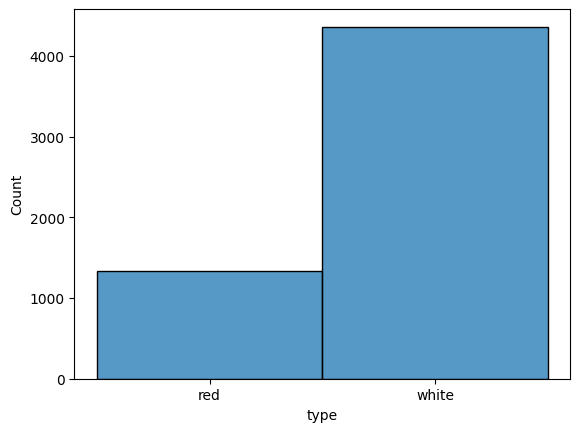

In [14]:
sns.histplot(wine['type'])
plt.show()

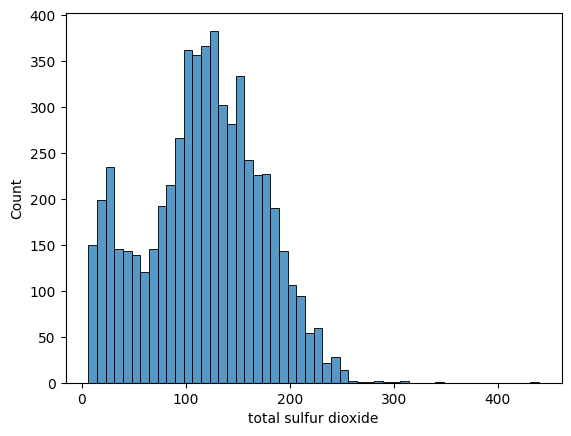

In [20]:
sns.histplot(wine['total sulfur dioxide'])
plt.show()

In [51]:
def exploracion(df: pd.DataFrame, bins=20):

    data = {col: df[col] for col in df.columns}

    n_vars = len(data)

    palette = sns.color_palette("Set2", n_colors=n_vars)
    
    # Crear figura con n filas y 2 columnas
    fig, axes = plt.subplots(n_vars, 2, figsize=(10, 3*n_vars))
    
    # Si hay solo una variable, convertir axes a lista para iterar
    if n_vars == 1:
        axes = [axes]
    
    # Iterar por cada variable
    for i, (var, values) in enumerate(data.items()):
        # Boxplot vertical
        sns.boxplot(x=values, ax=axes[i][0], color=palette[i], vert=True)
        axes[i][0].set_title(f"Boxplot de {var}")
        
        # Histograma a la derecha
        sns.histplot(values, bins=bins, color=palette[i], edgecolor="black", ax=axes[i][1])
        axes[i][1].set_title(f"Histograma de {var}")
    
    # Ajustar espaciado
    plt.tight_layout()
    plt.savefig("exploracion.png", dpi=100, bbox_inches="tight")
    plt.show()

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def exploracion(df: pd.DataFrame, bins=20):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        raise ValueError("No hay columnas numéricas.")

    n = len(num_cols)
    fig, axes = plt.subplots(n, 2, figsize=(8, 2*n), squeeze=False)

    for i, col in enumerate(num_cols):
        # 1) Limpiar: numérico, finito, sin NaN
        s = pd.to_numeric(df[col], errors="coerce")
        s = s.replace([np.inf, -np.inf], np.nan).dropna()

        # Histograma (derecha): si no hay datos, avisar
        if s.empty:
            axes[i, 0].axis("off")
            axes[i, 1].text(0.5, 0.5, f"Sin datos válidos en '{col}'",
                            ha="center", va="center")
            axes[i, 1].set_axis_off()
            continue

        # 2) BOX PLOT (izquierda) con “fallbacks”
        unique_vals = s.nunique(dropna=True)

        if unique_vals < 2:
            # Caso: 1 solo valor → dibuja línea vertical + rug para que se vea
            v = s.iloc[0]
            axes[i, 0].axvline(v, color="tab:blue", linewidth=3)
            # pequeño rango para que no quede pegado a los bordes
            eps = 1e-6 if v == 0 else abs(v) * 0.02
            axes[i, 0].set_xlim(v - eps, v + eps)
            axes[i, 0].set_title(f"Boxplot de {col} (único valor)")
            # Rug para contar puntos
            sns.rugplot(x=s, ax=axes[i, 0], height=0.1)
        else:
            q1, q3 = s.quantile([0.25, 0.75])
            iqr = q3 - q1
            if iqr == 0:
                # Caso: IQR cero → se verá muy fino; dibuja box y además rug
                axes[i, 0].boxplot(s.values, vert=False, patch_artist=True,
                                   boxprops=dict(facecolor="#a6cee3"),
                                   medianprops=dict(color="black"))
                sns.rugplot(x=s, ax=axes[i, 0], height=0.1)
                axes[i, 0].set_title(f"Boxplot de {col} (IQR=0)")
            else:
                # Caso normal
                axes[i, 0].boxplot(s.values, vert=False, patch_artist=True,
                                   boxprops=dict(facecolor="#a6cee3"),
                                   medianprops=dict(color="black"))
                axes[i, 0].set_title(f"Boxplot de {col}")

        axes[i, 0].set_yticks([])

        # 3) HISTOGRAMA (derecha)
        sns.histplot(s, bins=bins, ax=axes[i, 1],
                     color="#4da3d9", edgecolor="black", alpha=0.7)
        axes[i, 1].set_title(f"Histograma de {col}")

    plt.tight_layout()
    
    plt.show()

In [73]:
def exploracion(df: pd.DataFrame, bins=20):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        raise ValueError("No hay columnas numéricas.")

    n = len(num_cols)
    
    # Paleta de colores (tantos como variables)
    palette = sns.color_palette("Set2", n)
    
    # gridspec_kw → col 0 (boxplot) pesa 1, col 1 (histograma) pesa 2
    fig, axes = plt.subplots(
        n, 2, figsize=(12, 2.5*n),
        gridspec_kw={'width_ratios': [1.8, 2]},
        squeeze=False
    )

    for i, col in enumerate(num_cols):
        color = palette[i]
        
        # limpiar datos
        s = pd.to_numeric(df[col], errors="coerce")
        s = s.replace([np.inf, -np.inf], np.nan).dropna()

        # Boxplot a la izquierda
        '''axes[i, 0].boxplot(
            s.values, vert=False, patch_artist=True,
            boxprops=dict(facecolor=color, alpha=0.5),
            medianprops=dict(color="black")
        )'''

        axes[i, 0].boxplot(
            s.values,
            vert=False,
            patch_artist=True,
            whis=1.5,                 # regla de Tukey
            showfliers=True,          # mostrar outliers
            boxprops=dict(facecolor=color, alpha=0.5),
            medianprops=dict(color="black"),
            whiskerprops=dict(color=color, linewidth=1.5),
            capprops=dict(color=color, linewidth=1.5),
            flierprops=dict(          # estilo de los puntos atípicos
                marker='o', markersize=4,
                markerfacecolor=color, markeredgecolor='black', alpha=0.9
            )
        )

        axes[i, 0].set_title(f"Boxplot de {col}")
        axes[i, 0].set_yticks([])


        # Histograma a la derecha
        sns.histplot(s, bins=bins, ax=axes[i, 1],
                     color=color, edgecolor="black", alpha=0.7)
        axes[i, 1].set_title(f"Histograma de {col}")

    plt.tight_layout()
    plt.savefig("exploracion.png", dpi=100, bbox_inches="tight")
    plt.show()


In [85]:
std = wine['chlorides'].std()
mu = wine['chlorides'].mean()

In [91]:
dir(wine['chlorides'])

['T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__bool__',
 '__class__',
 '__column_consortium_standard__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pandas_priority__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__

In [92]:
wine['chlorides'].quantile(0.75)

0.065

In [94]:
q1 = wine['chlorides'].quantile(0.25)
q3 = wine['chlorides'].quantile(0.75)
iqr = q3 - q1

In [95]:
q1 - 1.5*iqr

-0.002500000000000009

In [98]:
q3 + 1.5*iqr

0.10550000000000001

In [99]:
#import pandas as pd

# Definir bordes de los intervalos
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]

# Crear variable categórica ordenada
wine["chlorides_cat"] = pd.cut(
    wine["chlorides"],
    bins=bins,
    right=False,  # intervalo cerrado a la izquierda, abierto a la derecha
    ordered=True
)

# Ver distribución de frecuencias
conteo = wine["chlorides_cat"].value_counts().sort_index()
print(conteo)

chlorides_cat
[0.0, 0.1)    6151
[0.1, 0.2)     286
[0.2, 0.3)      36
[0.3, 0.4)      11
[0.4, 0.5)      11
[0.5, 1.0)       2
Name: count, dtype: int64


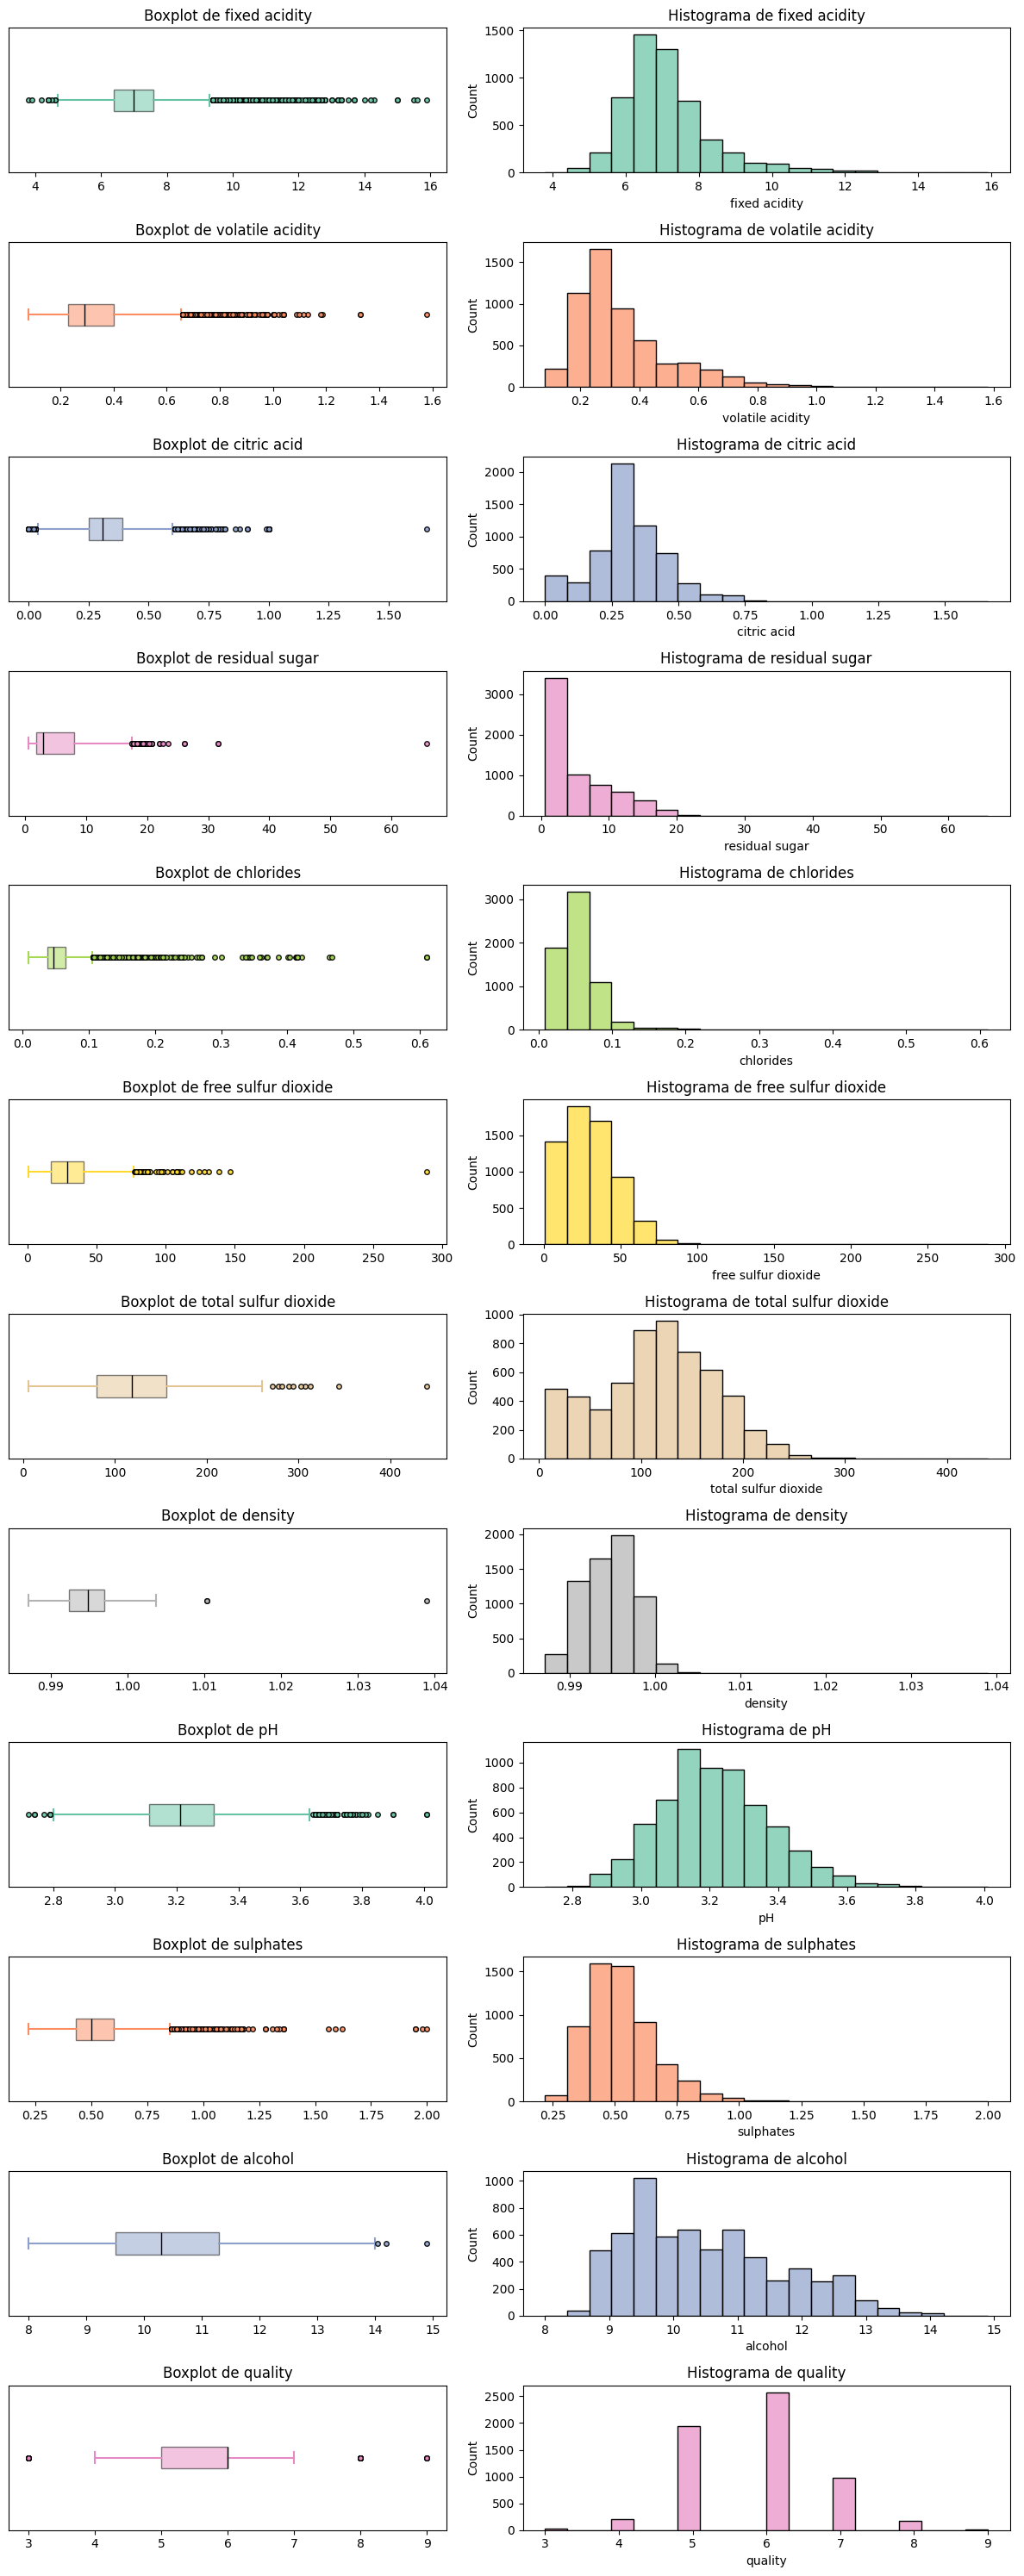

In [74]:
exploracion(wine)

In [72]:
wine.shape

(6497, 13)

In [75]:
wine[~wine['chlorides'].isna()]['chlorides'].describe()

count    6497.000000
mean        0.056034
std         0.035034
min         0.009000
25%         0.038000
50%         0.047000
75%         0.065000
max         0.611000
Name: chlorides, dtype: float64

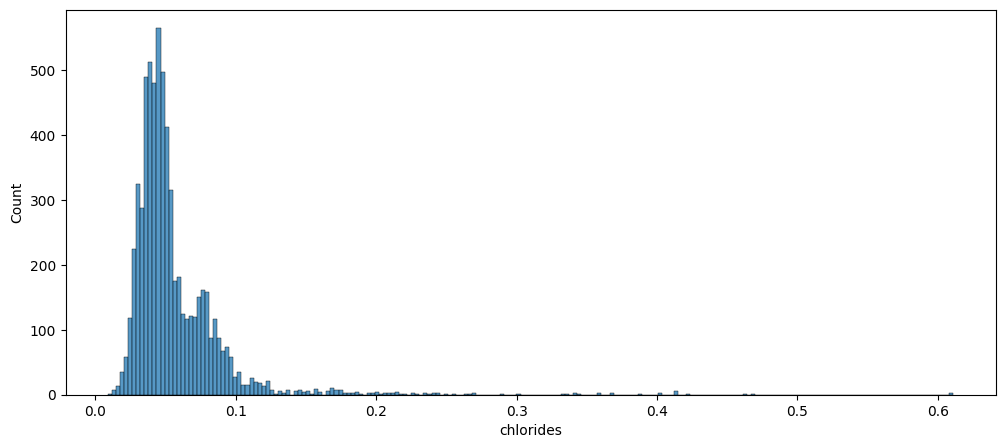

In [82]:
plt.figure(figsize=(12,5))
sns.histplot(wine['chlorides'])
plt.show()

In [76]:
wine[wine['chlorides'] > 0.65]['chlorides'].shape

(0,)

In [63]:
#Detectar
def detect_outliers_iforest(df, n_estimators=100, contamination=0.01, random_state=1989):
    model = IForest(n_estimators=n_estimators, contamination=contamination, random_state=random_state)
    model.fit(df)
    preds = model.predict(df)
    return df[preds == 1]

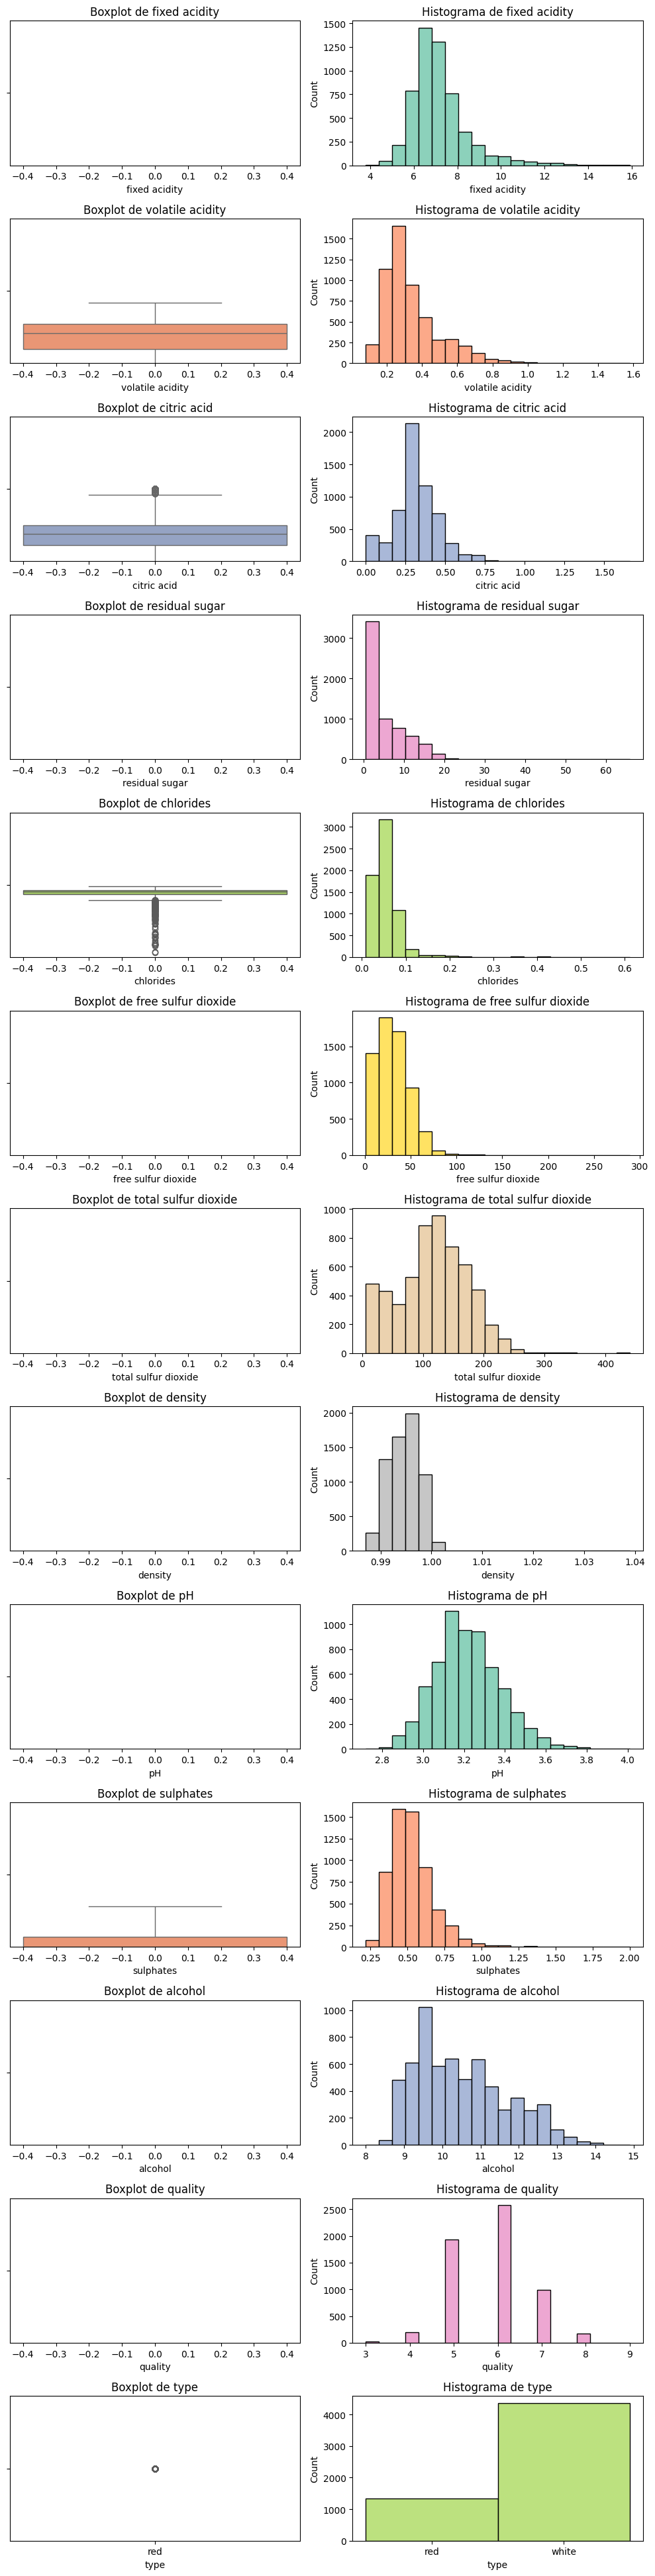

In [52]:
exploracion(wine)